Imported Required Libraries

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from datetime import datetime
import xml.etree.ElementTree as ET

Data Cleaning and Preprocessing for Youtube Data

In [75]:
def parse_youtube_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        soup = BeautifulSoup(file, 'html.parser')

    watch_history = []
    for entry in soup.find_all('div', class_='content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1'):
        text = entry.get_text(strip=True)
        watch_history.append(text)

    turkish_to_english_months = {
        "Oca": "Jan", "Şub": "Feb", "Mar": "Mar", "Nis": "Apr", "May": "May",
        "Haz": "Jun", "Tem": "Jul", "Ağu": "Aug", "Eyl": "Sep", "Eki": "Oct",
        "Kas": "Nov", "Ara": "Dec"
    }

    def convert_turkish_date_to_english(turkish_date):
        for turkish, english in turkish_to_english_months.items():
            turkish_date = turkish_date.replace(turkish, english)
        return turkish_date

    parsed_history = []
    for entry in watch_history:
        timestamp_match = re.search(r"\d{2} \w+ \d{4} \d{2}:\d{2}:\d{2}", entry)
        if timestamp_match:
            timestamp = timestamp_match.group(0)
            english_timestamp = convert_turkish_date_to_english(timestamp)
            datetime_obj = datetime.strptime(english_timestamp, '%d %b %Y %H:%M:%S')
            parsed_history.append({"Timestamp": datetime_obj})

    df_watch_history = pd.DataFrame(parsed_history)
    return df_watch_history

# Load YouTube data
df_watch_history = parse_youtube_data("/Users/sarpyilmaz/Desktop/dsa 210/izleme geçmişi.html")
df_watch_history['Timestamp'] = pd.to_datetime(df_watch_history['Timestamp'], errors='coerce')

# Filter data for October-November 2024
df_watch_history = df_watch_history[
    (df_watch_history['Timestamp'].dt.year == 2024) &
    (df_watch_history['Timestamp'].dt.month.isin([10, 11]))
]

# Add additional details for YouTube Watch History
df_watch_history['Day'] = df_watch_history['Timestamp'].dt.day_name()
df_watch_history['Hour'] = df_watch_history['Timestamp'].dt.hour
youtube_hourly = df_watch_history.groupby('Hour').size().reset_index(name='videos_watched')

Data Visualization for Youtube Data

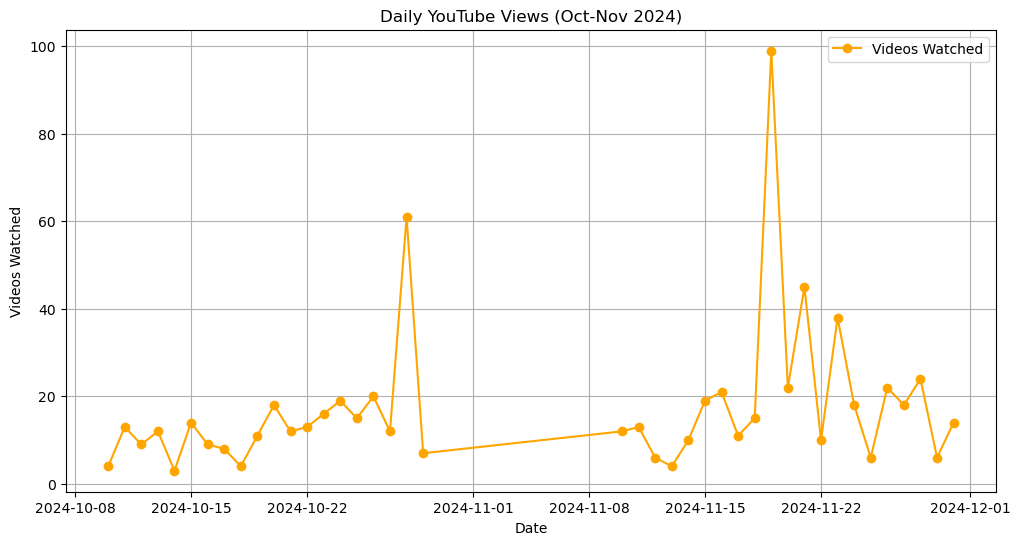

In [76]:
daily_views = df_watch_history.groupby(df_watch_history['Timestamp'].dt.date).size()
plt.figure(figsize=(12, 6))
plt.plot(daily_views.index, daily_views.values, marker='o', linestyle='-', color='orange', label='Videos Watched')
plt.title('Daily YouTube Views (Oct-Nov 2024)')
plt.xlabel('Date')
plt.ylabel('Videos Watched')
plt.grid()
plt.legend()
plt.show()

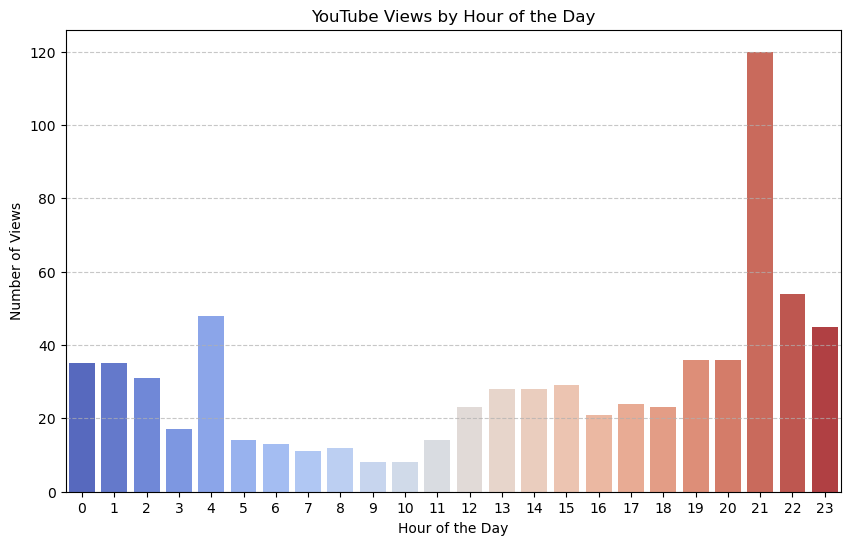

In [77]:
hourly_views = df_watch_history.groupby('Hour').size().reset_index(name='hourly_views')
plt.figure(figsize=(10, 6))
sns.barplot(data=hourly_views, x='Hour', y='hourly_views', palette='coolwarm')
plt.title("YouTube Views by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Views")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

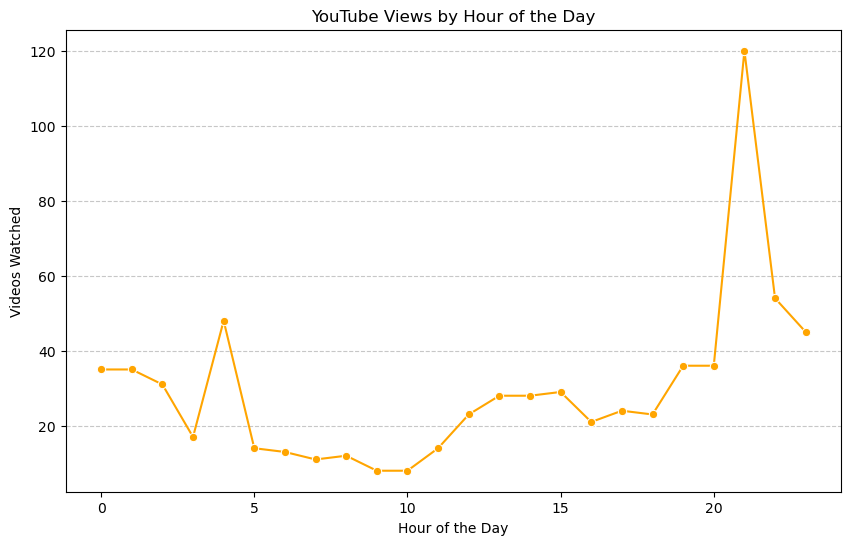

In [79]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=youtube_hourly, x='Hour', y='videos_watched', color='orange', marker='o')
plt.title("YouTube Views by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Videos Watched")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Data cleaning and preprocessing for Health (Step-count) Data

In [82]:
def parse_step_data(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    step_data = []
    for record in root.findall('.//Record'):
        if record.attrib.get('type') == 'HKQuantityTypeIdentifierStepCount':
            date = record.attrib.get('startDate')[:10]  # Extract date
            steps = float(record.attrib.get('value'))  # Step count value
            step_data.append({'date': date, 'steps': steps})
    step_df = pd.DataFrame(step_data)
    step_df['date'] = pd.to_datetime(step_df['date'], errors='coerce')
    step_df = step_df.groupby('date', as_index=False).sum()
    return step_df

# Load step count data
step_data = parse_step_data("/Users/sarpyilmaz/Desktop/dsa 210/export.xml")
step_data = step_data[
    (step_data['date'].dt.year == 2024) & 
    (step_data['date'].dt.month.isin([10, 11]))
]
step_data['Hour'] = step_data['date'].dt.hour  # Ensure 'Hour' column exists
step_hourly = step_data.groupby('Hour')['steps'].sum().reset_index()


Data Visualization for step count data

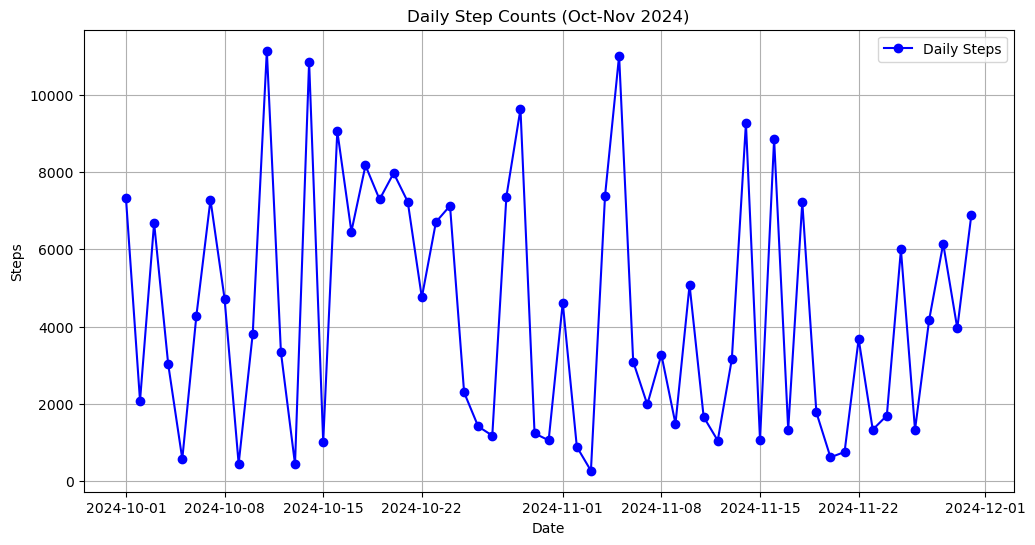

In [83]:
plt.figure(figsize=(12, 6))
plt.plot(step_data['date'], step_data['steps'], marker='o', linestyle='-', label='Daily Steps', color='blue')
plt.title('Daily Step Counts (Oct-Nov 2024)')
plt.xlabel('Date')
plt.ylabel('Steps')
plt.grid()
plt.legend()
plt.show()

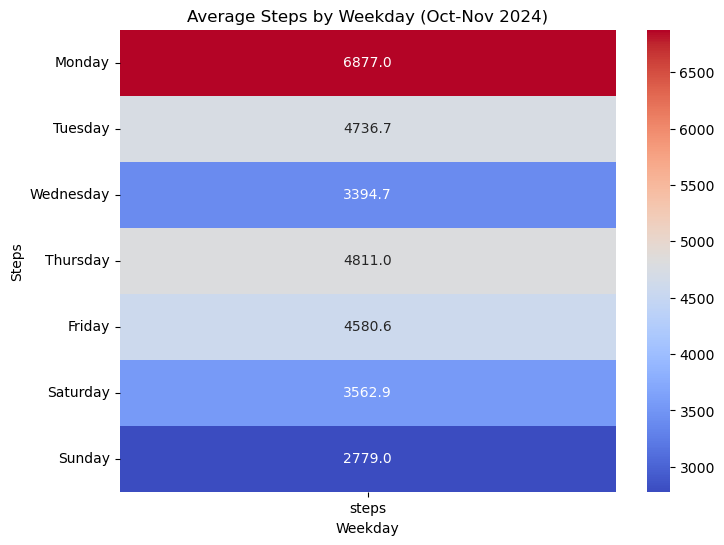

In [84]:
step_data['weekday'] = step_data['date'].dt.day_name()
weekday_steps = step_data.groupby('weekday')['steps'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(weekday_steps), annot=True, fmt=".1f", cmap="coolwarm")
plt.title('Average Steps by Weekday (Oct-Nov 2024)')
plt.xlabel('Weekday')
plt.ylabel('Steps')
plt.show()


Merging datas

In [65]:
# Ensure 'Timestamp' is a datetime object
df_watch_history['Timestamp'] = pd.to_datetime(df_watch_history['Timestamp'], errors='coerce')

# Ensure 'date' in step_data is a datetime object
step_data['date'] = pd.to_datetime(step_data['date'], errors='coerce')

# Convert to just the date part
df_watch_history['Timestamp'] = df_watch_history['Timestamp'].dt.date
step_data['date'] = step_data['date'].dt.date

# Merge the Data
merged_data = pd.merge(
    step_data.rename(columns={'date': 'Timestamp'}),
    df_watch_history.groupby('Timestamp').size().reset_index(name='videos_watched'),
    on='Timestamp', how='inner'
)

# Debugging: Inspect Merged Data
print("Merged Data Sample:\n", merged_data.head())
print("Correlation Between Steps and Videos Watched:\n", merged_data[['steps', 'videos_watched']].corr())

Merged Data Sample:
     Timestamp    steps       Day   weekday   step_Date        Date  \
0  2024-10-10   3818.0  Thursday  Thursday  2024-10-10  2024-10-10   
1  2024-10-11  11147.0    Friday    Friday  2024-10-11  2024-10-11   
2  2024-10-12   3336.0  Saturday  Saturday  2024-10-12  2024-10-12   
3  2024-10-13    433.0    Sunday    Sunday  2024-10-13  2024-10-13   
4  2024-10-14  10863.0    Monday    Monday  2024-10-14  2024-10-14   

   videos_watched  
0               4  
1              13  
2               9  
3              12  
4               3  
Correlation Between Steps and Videos Watched:
                    steps  videos_watched
steps           1.000000       -0.220819
videos_watched -0.220819        1.000000


In [66]:


print("Full Merged Data:\n", merged_data.to_string(index=False))

Full Merged Data:
  Timestamp   steps       Day   weekday  step_Date       Date  videos_watched
2024-10-10  3818.0  Thursday  Thursday 2024-10-10 2024-10-10               4
2024-10-11 11147.0    Friday    Friday 2024-10-11 2024-10-11              13
2024-10-12  3336.0  Saturday  Saturday 2024-10-12 2024-10-12               9
2024-10-13   433.0    Sunday    Sunday 2024-10-13 2024-10-13              12
2024-10-14 10863.0    Monday    Monday 2024-10-14 2024-10-14               3
2024-10-15  1012.0   Tuesday   Tuesday 2024-10-15 2024-10-15              14
2024-10-16  9065.0 Wednesday Wednesday 2024-10-16 2024-10-16               9
2024-10-17  6462.0  Thursday  Thursday 2024-10-17 2024-10-17               8
2024-10-18  8174.0    Friday    Friday 2024-10-18 2024-10-18               4
2024-10-19  7294.0  Saturday  Saturday 2024-10-19 2024-10-19              11
2024-10-20  7976.0    Sunday    Sunday 2024-10-20 2024-10-20              18
2024-10-21  7234.0    Monday    Monday 2024-10-21 2024-10

Hypothesis testing and Visualization of the merged data

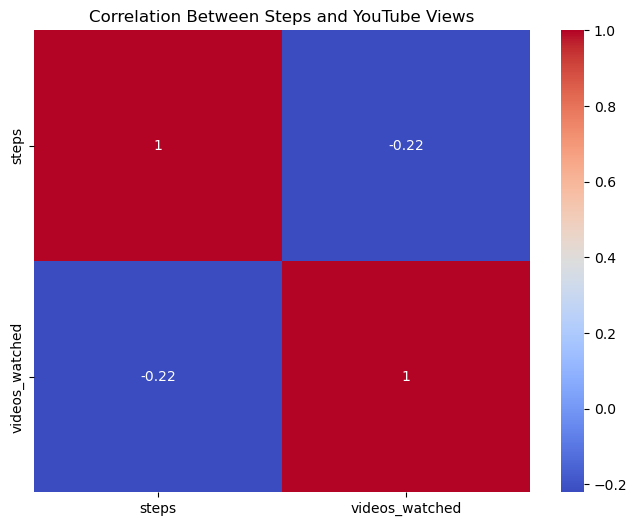

In [88]:
plt.figure(figsize=(8, 6))
sns.heatmap(merged_data[['steps', 'videos_watched']].corr(), annot=True, cmap="coolwarm")
plt.title('Correlation Between Steps and YouTube Views')
plt.show()



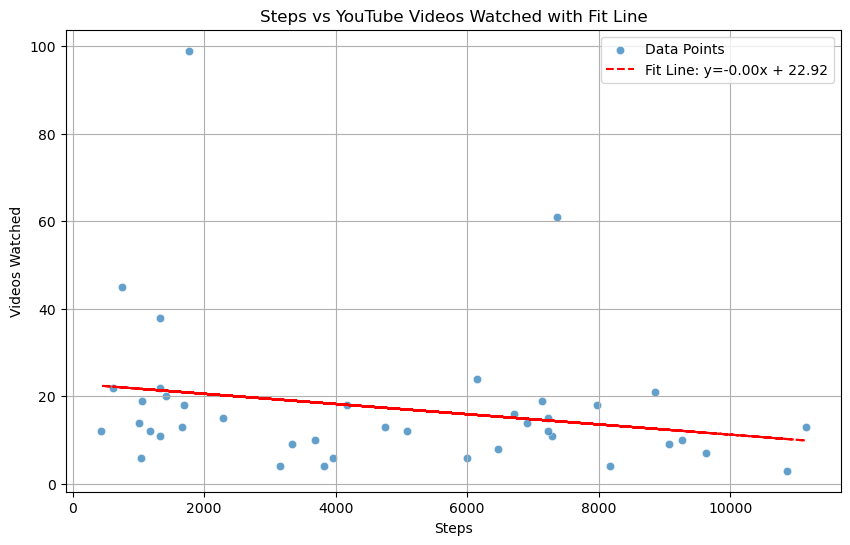

Fit Line Equation: y = -0.00x + 22.92
R-squared: 0.049


In [90]:
from scipy.stats import linregress

# Scatter Plot: Steps vs Videos Watched
plt.figure(figsize=(10, 6))

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(merged_data['steps'], merged_data['videos_watched'])

# Generate the fit line
fit_line = slope * merged_data['steps'] + intercept

# Plot the scatter plot
sns.scatterplot(data=merged_data, x='steps', y='videos_watched', alpha=0.7, label='Data Points')

# Plot the regression fit line
plt.plot(merged_data['steps'], fit_line, color='red', linestyle='--', label=f'Fit Line: y={slope:.2f}x + {intercept:.2f}')

# Add labels, title, and legend
plt.title('Steps vs YouTube Videos Watched with Fit Line')
plt.xlabel('Steps')
plt.ylabel('Videos Watched')
plt.legend()
plt.grid()
plt.show()

# Print the equation and R-squared value
print(f"Fit Line Equation: y = {slope:.2f}x + {intercept:.2f}")
print(f"R-squared: {r_value**2:.3f}")


Outlier analysis and hypothesis testing after outliers are neglected

Outlier Days in YouTube Views:
     Timestamp  YouTube Views
0  2024-10-28             61
1  2024-11-19             99
2  2024-11-21             45
3  2024-11-23             38
Step Counts for YouTube Outlier Days:
    Timestamp  YouTube Views   steps
0 2024-10-28             61  7366.0
1 2024-11-19             99  1774.0
2 2024-11-21             45   750.0
3 2024-11-23             38  1329.0


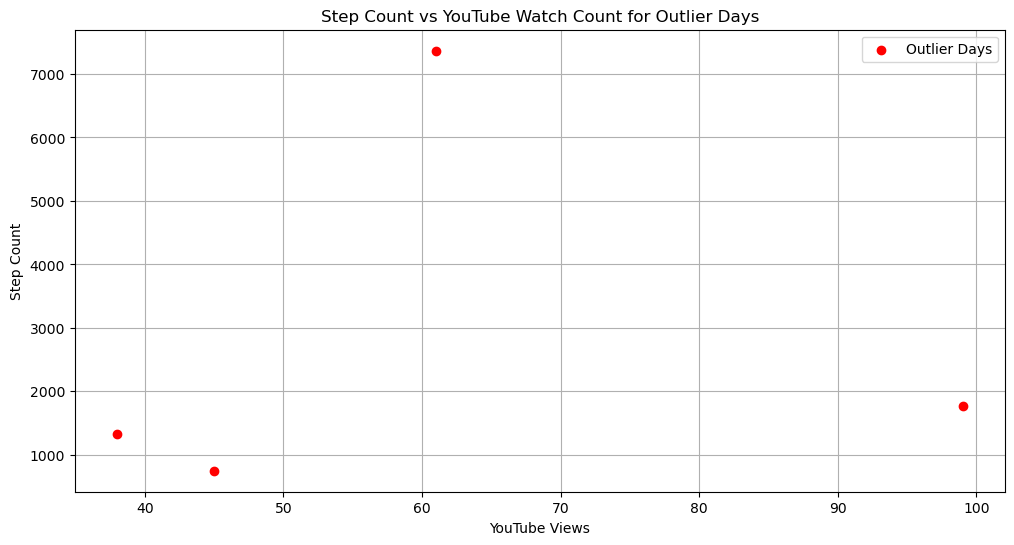

In [96]:
q1_views = daily_views.quantile(0.25)
q3_views = daily_views.quantile(0.75)
iqr_views = q3_views - q1_views
lower_bound_views = q1_views - 1.5 * iqr_views
upper_bound_views = q3_views + 1.5 * iqr_views

# Get Outlier Days for YouTube Views
outlier_days_views = daily_views[(daily_views < lower_bound_views) | (daily_views > upper_bound_views)]
outlier_days_views = outlier_days_views.reset_index()
outlier_days_views.columns = ['Timestamp', 'YouTube Views']

print("Outlier Days in YouTube Views:\n", outlier_days_views)

# Ensure Consistent Datetime Format for Merging
outlier_days_views['Timestamp'] = pd.to_datetime(outlier_days_views['Timestamp'])
step_data['Timestamp'] = pd.to_datetime(step_data['date'])

# Merge Outlier Days with Step Count Data
merged_outliers = pd.merge(outlier_days_views, step_data, on='Timestamp', how='left')

# Display Corresponding Step Counts for YouTube Outlier Days
print("Step Counts for YouTube Outlier Days:\n", merged_outliers[['Timestamp', 'YouTube Views', 'steps']])

# Plot the Corresponding Values
plt.figure(figsize=(12, 6))
plt.scatter(merged_outliers['YouTube Views'], merged_outliers['steps'], color='red', label='Outlier Days')
plt.title('Step Count vs YouTube Watch Count for Outlier Days')
plt.xlabel('YouTube Views')
plt.ylabel('Step Count')
plt.grid()
plt.legend()
plt.show()


### Hypothesis Testing Results ###
Pearson Correlation Coefficient (r): -0.2208
p-value: 0.1653
Conclusion: Reject the null hypothesis (H0).
There is NO significant relationship between daily YouTube usage and step counts.


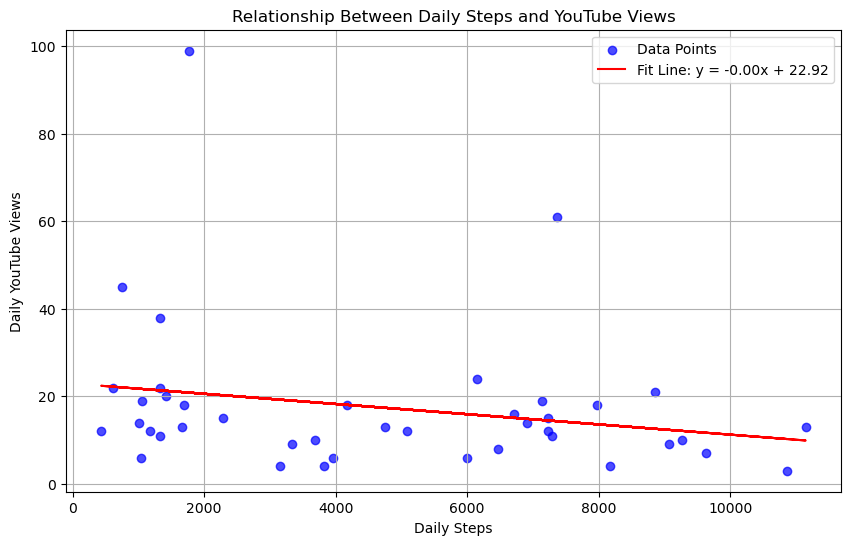

In [108]:
import pandas as pd
from scipy.stats import pearsonr

# Assuming merged_data contains 'steps' and 'videos_watched'
# Ensure your merged_data DataFrame is already loaded with daily data

# Calculate Pearson Correlation Coefficient
x = merged_data['steps']  # Step counts
y = merged_data['videos_watched']  # YouTube videos watched

# Perform Pearson Correlation Test
r, p_value = pearsonr(x, y)

# Print Results
print("### Hypothesis Testing Results ###")
print(f"Pearson Correlation Coefficient (r): {r:.4f}")
print(f"p-value: {p_value:.4f}")

# Hypothesis Testing Conclusion
alpha = 0.05  # Significance level

if p_value < alpha:
    print("Conclusion: Reject the null hypothesis (H0).")
    print("There IS significant relationship between daily YouTube usage and step counts.")
else:
    print("Conclusion: Fail to reject the null hypothesis (H0).")
    print("There is NO significant relationship between daily YouTube usage and step counts.")

# Step 4: Visualize the Relationship
# Scatter Plot with Regression Line
import numpy as np
plt.figure(figsize=(10, 6))
plt.scatter(daily_steps, daily_views, alpha=0.7, label="Data Points", color='blue')
m, b = np.polyfit(daily_steps, daily_views, 1)  # Fit line
plt.plot(daily_steps, m * daily_steps + b, color='red', label=f"Fit Line: y = {m:.2f}x + {b:.2f}")
plt.title("Relationship Between Daily Steps and YouTube Views")
plt.xlabel("Daily Steps")
plt.ylabel("Daily YouTube Views")
plt.grid()
plt.legend()
plt.show()


In [109]:
def remove_outliers(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Exclude Outliers for 'steps' and 'videos_watched'
filtered_data = remove_outliers(merged_data, 'steps')
filtered_data = remove_outliers(filtered_data, 'videos_watched')

# Recalculate Pearson Correlation
x_filtered = filtered_data['steps']
y_filtered = filtered_data['videos_watched']
r_filtered, p_value_filtered = pearsonr(x_filtered, y_filtered)


### Correlation After Removing Outliers ###
Pearson Correlation Coefficient (r): -0.2203
p-value: 0.1901

Correlation Matrix After Removing Outliers:
                   steps  videos_watched
steps           1.000000       -0.220289
videos_watched -0.220289        1.000000


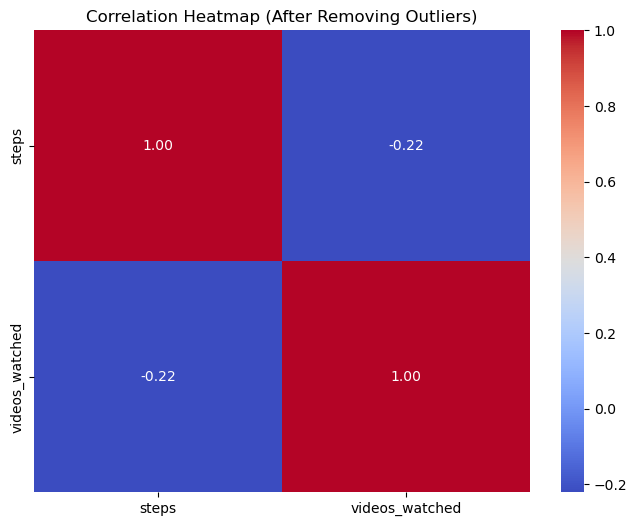

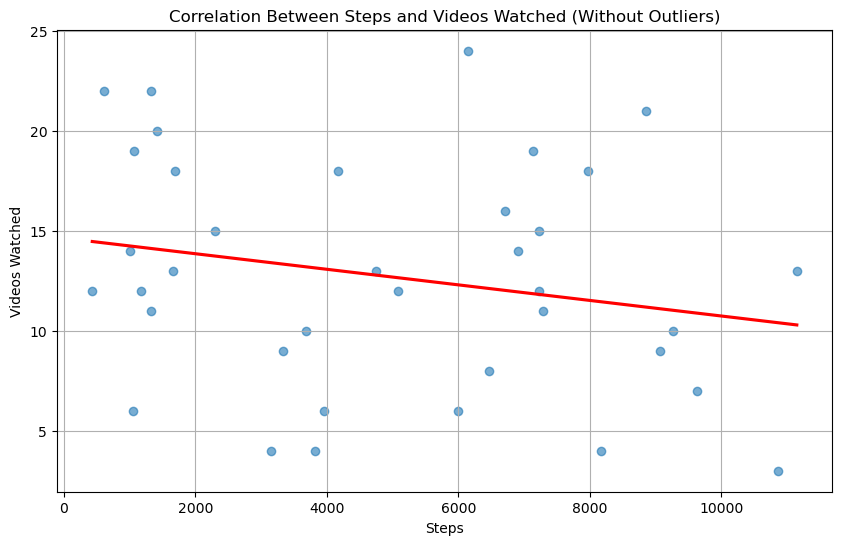

Conclusion: Fail to reject the null hypothesis (H0).
There is NO significant relationship between daily YouTube usage and step counts.


In [112]:
# Print Correlation Results
print("### Correlation After Removing Outliers ###")
print(f"Pearson Correlation Coefficient (r): {r_filtered:.4f}")
print(f"p-value: {p_value_filtered:.4f}")

# Correlation Matrix
correlation_matrix = filtered_data[['steps', 'videos_watched']].corr()
print("\nCorrelation Matrix After Removing Outliers:")
print(correlation_matrix)

# Plot Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (After Removing Outliers)')
plt.show()

# Plot Correlation Line
plt.figure(figsize=(10, 6))
sns.regplot(data=filtered_data, x='steps', y='videos_watched', ci=None, scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
plt.title('Correlation Between Steps and Videos Watched (Without Outliers)')
plt.xlabel('Steps')
plt.ylabel('Videos Watched')
plt.grid()
plt.show()

# Hypothesis Testing Conclusion
alpha = 0.05  # Significance level

if p_value < alpha:
    print("Conclusion: Reject the null hypothesis (H0).")
    print("There IS significant relationship between daily YouTube usage and step counts.")
else:
    print("Conclusion: Fail to reject the null hypothesis (H0).")
    print("There is NO significant relationship between daily YouTube usage and step counts.")


Tried hourly analysis but needs to be worked on more

Merged Hourly Data:
    Hour  videos_watched     steps
0      0              35  267020.0
1      1              35       0.0
2      2              31       0.0
3      3              17       0.0
4      4              48       0.0
5      5              14       0.0
6      6              13       0.0
7      7              11       0.0
8      8              12       0.0
9      9               8       0.0
10    10               8       0.0
11    11              14       0.0
12    12              23       0.0
13    13              28       0.0
14    14              28       0.0
15    15              29       0.0
16    16              21       0.0
17    17              24       0.0
18    18              23       0.0
19    19              36       0.0
20    20              36       0.0
21    21             120       0.0
22    22              54       0.0
23    23              45       0.0
Hourly Correlation:
                 videos_watched     steps
videos_watched        1.000000  0.048953
st

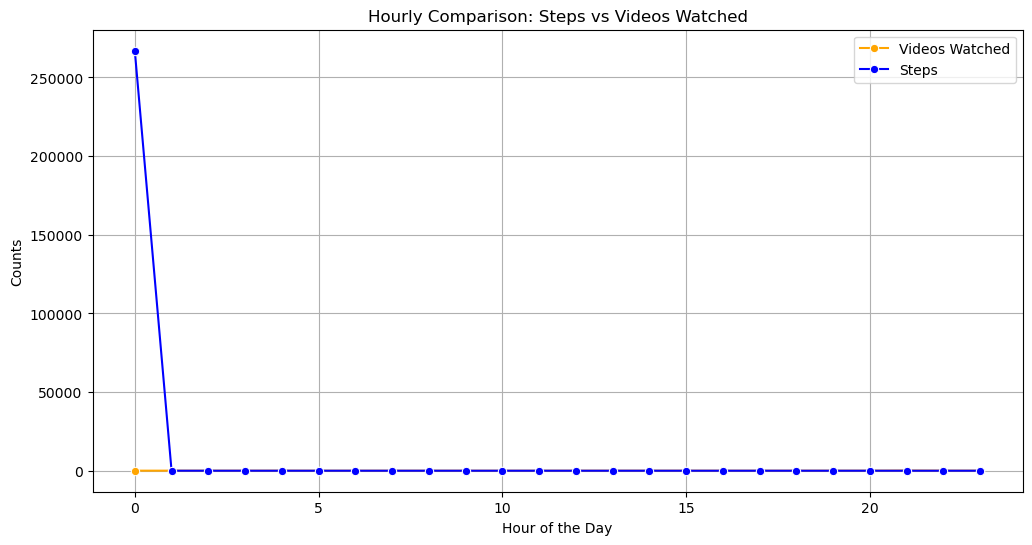

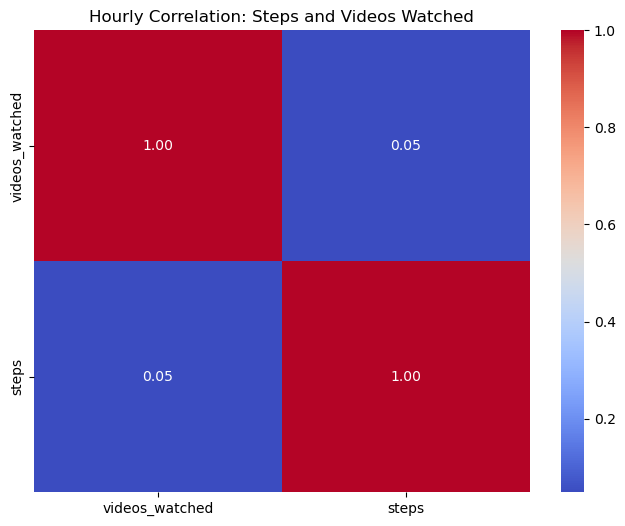

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/sarpyilmaz/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/c7/h_m6fpxd7tl3w_4ybvfgm7380000gn/T/ipykernel_62012/2549103181.py", line 43, in <module>
    hourly_data.to_csv("merged_hourly_data.csv", index=False)
  File "/Users/sarpyilmaz/anaconda3/lib/python3.10/site-packages/pandas/util/_decorators.py", line 211, in wrapper
    raise TypeError(msg)
  File "/Users/sarpyilmaz/anaconda3/lib/python3.10/site-packages/pandas/core/generic.py", line 3720, in to_csv
    str or None
  File "/Users/sarpyilmaz/anaconda3/lib/python3.10/site-packages/pandas/util/_decorators.py", line 211, in wrapper
    raise TypeError(msg)
  File "/Users/sarpyilmaz/anaconda3/lib/python3.10/site-packages/pandas/io/formats/format.py", line 1162, in to_csv
  File "/Users/sarpyilmaz/anaconda3/lib/python3.10/site-packages/pandas/io/formats/csvs.py", 

In [102]:
# Ensure 'Hour' is properly set as integer for both datasets
youtube_hourly['Hour'] = youtube_hourly['Hour'].astype(int)
step_hourly['Hour'] = step_hourly['Hour'].astype(int)

# Generate a full range of hours (0 to 23) to handle missing data
all_hours = pd.DataFrame({'Hour': range(24)})

# Merge with all_hours to ensure every hour is accounted for
youtube_hourly = pd.merge(all_hours, youtube_hourly, on='Hour', how='left').fillna(0)
step_hourly = pd.merge(all_hours, step_hourly, on='Hour', how='left').fillna(0)

# Merge YouTube and Step Data on 'Hour'
hourly_data = pd.merge(youtube_hourly, step_hourly, on='Hour', suffixes=('_youtube', '_steps'))

# Debugging: Inspect Merged Data
print("Merged Hourly Data:")
print(hourly_data)

# Correlation Analysis
hourly_correlation = hourly_data[['videos_watched', 'steps']].corr()
print("Hourly Correlation:\n", hourly_correlation)

# --- Hourly Plots ---

# Plot for Videos Watched and Steps by Hour
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_data, x='Hour', y='videos_watched', color='orange', marker='o', label='Videos Watched')
sns.lineplot(data=hourly_data, x='Hour', y='steps', color='blue', marker='o', label='Steps')
plt.title('Hourly Comparison: Steps vs Videos Watched')
plt.xlabel('Hour of the Day')
plt.ylabel('Counts')
plt.grid()
plt.legend()
plt.show()

# Plot Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(hourly_correlation, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Hourly Correlation: Steps and Videos Watched")
plt.show()

# Save the merged hourly data
hourly_data.to_csv("merged_hourly_data.csv", index=False)
print("Merged hourly data saved to 'merged_hourly_data.csv'.")